In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [2]:
%matplotlib inline

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re

sns.set();
sns.set_palette("colorblind")

from IPython.display import display, display_html, HTML
from IPython.core.debugger import set_trace
# plt.rcParams["axes.grid"] = False

import Jupyter_module_loader
from utility import *
import gaussian_kde

import warnings
warnings.filterwarnings('ignore')

import holoviews as hv
from holoviews import opts

encoding = "ISO-8859-1"

In [3]:
dataset_name = "W19_comb"
df_list = [ "BES_Panel", "BES_reduced_with_na","BES_reduced"]

In [4]:
# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
# %matplotlib inline
(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()

global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

for df in df_list:
    if df=="BES_Panel":
#         globals()[df]  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
        globals()[df]  = pd.read_pickle(data_subfolder + dataset_filename.replace('.dta','.zip'),compression='zip')
    else:
        globals()[df]  = pd.read_pickle(data_subfolder + df + '.zip' )
        globals()[df].replace(-1,np.nan,inplace=True)
  
(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

# get full set of inferred "cross wave" auth-lib/left-right values and ages
pan_dataset_allr_values = pd.read_csv(BES_small_data_files + "pan_dataset_allr_values"+".csv")
pan_dataset_ages = pd.read_csv( BES_small_data_files + "pan_dataset_ages"+".csv" )

var_type (7911, 14)


In [5]:
# helper functions
global best_weight_series
def weighted_mean(series):
    return (series*best_weight_series.loc[series.index]).sum()/(best_weight_series.loc[series.index]).sum()

from pandas._libs.lib import is_integer

def weighted_qcut(values, weights, q, **kwargs):
    if is_integer(q):
        quantiles = np.linspace(0, 1, q + 1)
    else:
        quantiles = q
    order = weights[values.argsort()].cumsum()
    bins = pd.cut(order / order.iloc[-1], quantiles, **kwargs)
    return bins.sort_index()

# CHEATY FIX FOR WEIGHTING SEABORN KDES BEFORE THEY FIX SEABORN TO PASS WEIGHTS

# so we take in a series of weights - either assumes/force it to be non-null floats [0-inf)
# flip coins for the fractional parts of the weights to round up/down proportionately
# then replicate rows on the basis of the resulting weights

def lazy_weighted_indices(weights):
    x = weights.apply(lambda x: np.floor(x) if (np.random.rand() > x%1) else np.ceil(x)).astype('int')
    return flatten( [[weights.index[ind]]*x.values[ind] for ind in range(weights.shape[0])] )

def weighted_value_counts(x, wts, *args, **kwargs):
    normalize = kwargs.get('normalize', False)
    perc = kwargs.get('perc', False)
    decimal_places = kwargs.get('decimal_places', 2)
    suppress_raw_samplesize = kwargs.get('suppress_raw_samplesize', False)
    
    ascending = kwargs.get('ascending', True)
    c0 = x.name 
    c1 = wts.name
    df = pd.concat([x,wts],axis=1)
    xtmp = df.groupby(c0).agg({c1:'sum'}).sort_values(c1,ascending=False)
    s = pd.Series(index=xtmp.index, data=xtmp[c1], name=c0)
    s.name = "weighted_sample_size"
    if normalize:
        s = s / df[c1].sum()
        s.name = "weighted_sample_fraction"
    if normalize and perc:
        s = s*100
        s.name = "weighted_sample_percentage"
    s = s.round(decimal_places)
    if decimal_places==0:
        s=s.astype('int')
        
    if not suppress_raw_samplesize:
        output = pd.DataFrame([s,x[wts.notnull()].value_counts()]).T
        output.columns = [s.name,"raw_sample_size"]
        output.index.name = x.name
        output.sort_values(by=s.name,inplace=True, ascending=ascending)
    else:
        output = s
    return output

import random
 
def distinct_colors(n):
  ret = []
  r = 128+int(random.random() * 128)
  g = 128+int(random.random() * 128)
  b = 128+int(random.random() * 128)
  step = 128 / n
  for i in range(n):
    r += step
    g += step
    b += step
    r = 128+ (int(r) % 128)
    g = 128+ (int(g) % 128)
    b = 128+ (int(b) % 128)
    ret.append((r/255,g/255,b/255)) 
  return ret

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def fix_BESW16_variable_order():
    leftRight_cats = ['Left', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Right',       "Don't know"]
    howToReduceDeficit_cats = ['Only by increasing taxes','Mainly by increasing taxes, but also by cutting spending','An equal balance of spending cuts and tax increases', 
                               'Mainly by cutting spending, but with some tax increases','Only by cutting spending',"Don't know"   ]
    cutsTooFarNational_cats = ['Not gone nearly far enough', 'Not gone far enough', 'About right', 'Gone too far','Gone much too far', "Don't know"]
    taxSpendSelf_cats = ['Government should cut taxes a lot and spend much less on health and social services','1', '2', '3', '4', '5', '6', '7', '8', '9',       
                         'Government should increase taxes a lot and spend much more on health and social services', "Don't know"]
    spend_cats = [ 'Spend much less','Spend less', 'Spend the same as now', 'Spend more','Spend much more',"Don't know"]
    ageGroup_cats = ['Under 18', '18-25', '26-35', '36-45', '46-55', '56-65', '66+']    
    
    BES_Panel[match(BES_Panel,"lr[^0-9_]|leftRight").index] = \
        BES_Panel[match(BES_Panel,"lr[^0-9_]|leftRight").index]\
            .apply(lambda x: x.cat.reorder_categories(leftRight_cats))    
    
    for like_var in BES_Panel.columns:
        if re.match("^ptv(?!expgrp)", like_var):
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(['Very unlikely','1', '2', '3', '4', '5', '6', '7', '8', '9',
                       'Very likely', "Don't know" ]))    
        elif "like" in like_var:
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(['Strongly dislike','1', '2', '3', '4', '5', '6', '7', '8', '9', "Don't know",
        'Strongly like']))                
        elif "immigEcon" in like_var:
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(['Bad for economy', '2', '3', '4', '5', '6', 'Good for economy',
       "Don't know"]))  
        elif "immigCultural" in like_var:
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(['Undermines cultural life', '2', '3', '4', '5', '6',
       'Enriches cultural life', "Don't know"]))     
        elif "immigrantsWelfareState" in like_var:
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(['Strongly disagree', 'Disagree', 'Neither agree nor disagree',
       'Agree','Strongly agree',  "Don't know"]))  
        elif "deficitReduce" in like_var:
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(['It is completely necessary','It is important but not absolutely  necessary','It is not necessary but it would be desirable','It is completely unnecessary',"Don't know"]))  
        elif "howToReduceDeficit" in like_var:
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(howToReduceDeficit_cats))  

        elif "taxSpendSelf" in like_var:
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(taxSpendSelf_cats))
            


In [5]:
BES_Panel = pd.read_pickle("..\\BES_analysis_data\\"+"W19_comb"+os.sep+"BES2019_W19_Panel_v0.1.zip",compression='zip')

0         True
1         True
2        False
3         True
4        False
         ...  
97153    False
97154    False
97155    False
97156    False
97157    False
Length: 97158, dtype: bool

In [7]:
search(BES_Panel,"generalElectionVote")

generalElectionVoteW1              30546
generalElectionVoteW2              30249
generalElectionVoteW3              28296
generalElectionVoteW4              31547
generalElectionVoteUnsqueezeW4     20884
generalElectionVoteSqueezeW4        9399
generalElectionVoteW5              30508
generalElectionVotePostW5           3241
generalElectionVoteUnsqueezeW5     19487
generalElectionVoteSqueezeW5        6814
generalElectionVoteW6              27838
generalElectionVoteW7              30895
generalElectionVoteW8              33502
generalElectionVoteW9              30036
generalElectionVoteW10             30237
generalElectionVoteW11             30956
generalElectionVoteUnsqueezeW11    20488
generalElectionVoteSqueezeW11       9330
generalElectionVoteW12             34394
generalElectionVotePostW12          4335
generalElectionVoteUnsqueezeW12    21316
generalElectionVoteSqueezeW12       7389
generalElectionVoteW13             28297
generalElectionVoteW14             31063
generalElectionV

In [9]:
BES_Panel["generalElectionVoteW19"].value_counts()

Conservative                                12872
Labour                                       8426
Liberal Democrat                             3640
Scottish National Party (SNP)                1269
Green Party                                   903
Brexit Party                                  747
Other                                         337
Don't know                                    264
An independent candidate                      230
Plaid Cymru                                   181
United Kingdom Independence Party (UKIP)       32
Name: generalElectionVoteW19, dtype: int64

In [10]:
BES_Panel["generalElectionVoteNonVoterW19"]

0                NaN
1                NaN
2                NaN
3        Plaid Cymru
4                NaN
            ...     
97153            NaN
97154            NaN
97155            NaN
97156            NaN
97157            NaN
Name: generalElectionVoteNonVoterW19, Length: 97158, dtype: category
Categories (11, object): [Conservative < Labour < Liberal Democrat < Scottish National Party (SNP) ... Other < Brexit Party < An independent candidate < Don't know]

In [11]:
def lazy_weighted_indices(weights):
    x = weights.apply(lambda x: np.floor(x) if (np.random.rand() > x%1) else np.ceil(x)).astype('int')
    return flatten( [[weights.index[ind]]*x.values[ind] for ind in range(weights.shape[0])] )

In [13]:
search(BES_Panel,"^Age|^age",mask=BES_Panel["generalElectionVoteW19"].notnull())

ageW1        8495
ageW7       11569
ageW8       13010
ageW9       12612
ageW11      13881
ageW12      14749
ageW13      14488
ageW14      15214
ageW16      19421
ageW17      20648
ageW18      23600
ageW19      28901
ageW15      16255
ageGroup    17950
Age         17950
dtype: int64

In [ ]:
# Age
# generalElectionVoteW19

# first time Tories = 




In [11]:
NoCon20052017 = (BES_Panel[search(BES_Panel,"profile_past").index]!="Conservative").all(axis=1)
df = BES_Panel[["generalElectionVoteW19"]].copy()
# df["generalElectionVoteW19"].cat.add_categories("First time Conservative",inplace=True)

df.loc[(df["generalElectionVoteW19"] =="Conservative")& NoCon20052017,"generalElectionVoteW19"] = "First time Conservative"

ValueError: Cannot setitem on a Categorical with a new category, set the categories first

In [88]:
df["generalElectionVoteW19"].value_counts()

Conservative                                12014
Labour                                       8426
Liberal Democrat                             3640
Scottish National Party (SNP)                1269
Green Party                                   903
First time Conservative                       858
Brexit Party                                  747
Other                                         337
Don't know                                    264
An independent candidate                      230
Plaid Cymru                                   181
United Kingdom Independence Party (UKIP)       32
Name: generalElectionVoteW19, dtype: int64

In [89]:
df["Age"] = BES_Panel["Age"]
df["eurefVote"] = BES_Panel["profile_eurefvote"].cat.remove_categories("Don't know")
df["gender"] = BES_Panel["gender"]
df["generalElectionVoteW19"] = df["generalElectionVoteW19"].replace("Conservative","Conservative (not First Time)")

In [90]:
# search(BES_Panel,"wt.*W19",mask = BES_Panel["generalElectionVoteW19"].notnull())

weights = BES_Panel["wt_new_W19_result"]

In [91]:
mask = weights.notnull() & df.notnull().all(axis=1)
df = df[mask]
mask.sum()

17007

In [92]:
search(BES_Panel,"euref",mask=mask).sort_values()

euRefVoteHypotheticalW9        0
euRefpastVoteW14               0
euRefTurnoutRetroW14           0
euRefTurnoutRetroW17           0
euRefpastVoteW17               0
                           ...  
euRefVoteW12               13825
profile_eurefvote          17007
euRefDoOverW19             17007
euRefVoteW19               17007
profile_eurefturnout       17007
Length: 67, dtype: int64

In [93]:
weighted_ids = lazy_weighted_indices(weights[mask])

In [94]:
# df["generalElectionVoteW19"].cat.categories

order = ['Conservative (not First Time)', 'First time Conservative', 'Brexit Party', 'Labour', 'Liberal Democrat',
       'Scottish National Party (SNP)', 'Plaid Cymru',
       'United Kingdom Independence Party (UKIP)', 'Green Party', 'Other',
        'An independent candidate', "Don't know",
       ]

Text(0.5, 1.0, 'Age Distribution by 2019 Vote Choice (split by eurefVote)')

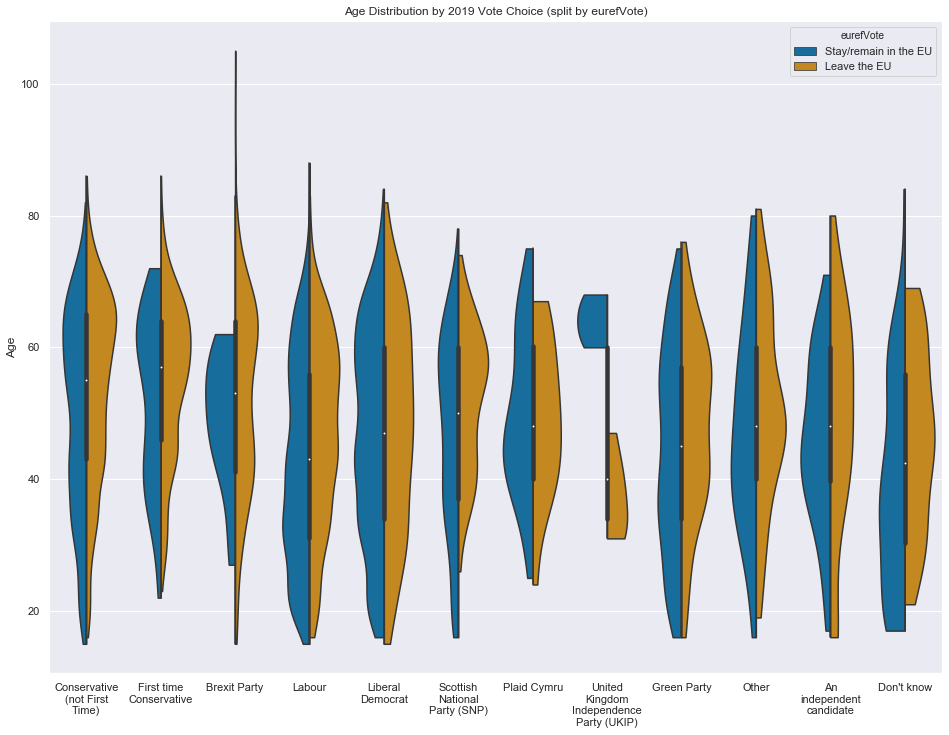

In [97]:
import textwrap
plt.figure(figsize=(16,12))
sns.violinplot(data = df.loc[weighted_ids],x="generalElectionVoteW19",y="Age",hue="eurefVote",split=True,cut=0, order=order);
# plt.xticks()
plt.gca().set_xticklabels([textwrap.fill(e, 12) for e in order]);
plt.xlabel("");
plt.title("Age Distribution by 2019 Vote Choice (split by eurefVote)");

Text(0.5, 1.0, 'Age Distribution by 2019 Vote Choice (split by gender)')

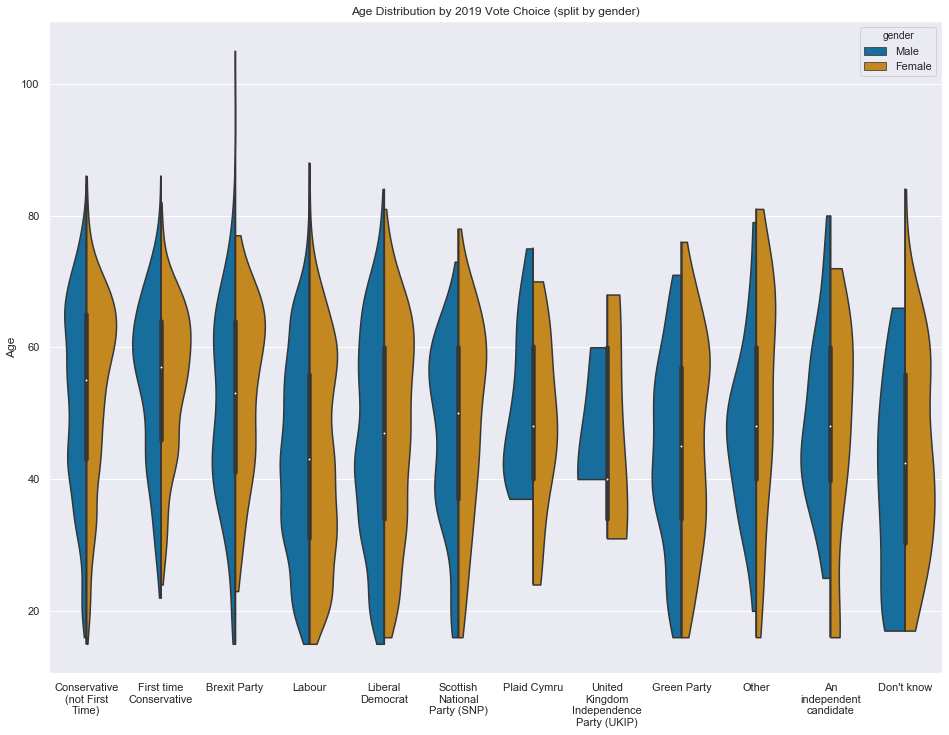

In [98]:
import textwrap
plt.figure(figsize=(16,12))
sns.violinplot(data = df.loc[weighted_ids],x="generalElectionVoteW19",y="Age",hue="gender",split=True,cut=0, order=order);
# plt.xticks()
plt.gca().set_xticklabels([textwrap.fill(e, 12) for e in order]);
plt.xlabel("");
plt.title("Age Distribution by 2019 Vote Choice (split by gender)");

In [ ]:
### Factor Analysis

In [10]:
%%time

df = BES_reduced

# df = df.fillna(df.mean())




output_subfolder = BES_output_folder+os.sep + "W19_comb" + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )
    

# standardise data (subtract out the mean, divide through by standard deviation)
clean_feature_set_std = StandardScaler().fit_transform(df.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = df.columns,
                             index   = df.index      )



n_components = BES_std.shape[1]
# n_components = 2
alpha = 18
decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
# decomp = SparsePCA(n_components = n_components, alpha = alpha)
decomp_method = str(decomp).split("(")[0] 
# ,n_components=30

X_r = decomp.fit_transform(BES_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = df.index)



load_suff = "FactorAnalysis"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method


# display_pca_data(n_components, decomp, BES_std)



(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          df.columns, BES_decomp, manifest=manifest, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 10, show_histogram = True)

MemoryError: Unable to allocate array with shape (97158, 11963) and data type float64

In [14]:
BES_Panel["First_time_Conservative"] = (df["generalElectionVoteW19"] =="Conservative")& NoCon20052017

In [10]:
NoCon20052017 = (BES_Panel[search(BES_Panel,"profile_past").index]!="Conservative").all(axis=1)
# df = BES_Panel[["generalElectionVoteW19"]].copy()
# # df["generalElectionVoteW19"].cat.add_categories("First time Conservative",inplace=True)

# df.loc[(df["generalElectionVoteW19"] =="Conservative")& NoCon20052017,"generalElectionVoteW19"] = "First time Conservative"

In [11]:
BES_reduced_with_na["First_time_Conservative"] = (BES_Panel["generalElectionVoteW19"] =="Conservative")& NoCon20052017

In [27]:
BES_reduced_with_na["First_time_Conservative"][BES_Panel["generalElectionVoteW19"].isnull()] = np.nan

In [50]:
search(BES_Panel,"profile_past").index

Index(['profile_past_vote_2005', 'profile_past_vote_2010',
       'profile_past_vote_2017', 'profile_past_vote_2015'],
      dtype='object')

In [31]:
gc.collect()

95794

In [49]:
# corrs = BES_reduced_with_na.corrwith(BES_reduced_with_na["First_time_Conservative"])

In [32]:
BES_reduced_with_na["First_time_Conservative"]

0        False
1         True
2        False
3        False
4        False
         ...  
97153    False
97154    False
97155    False
97156    False
97157    False
Name: First_time_Conservative, Length: 97158, dtype: bool

In [33]:
BES_reduced_with_na.dtypes

turnoutUKGeneralW1__Very likely that I will vote       Int8
turnoutUKGeneralW2__Very likely that I will vote       Int8
turnoutUKGeneralW3__Very likely that I will vote       Int8
turnoutUKGeneralW4__Very likely that I will vote       Int8
turnoutUKGeneralW5__Very likely that I will vote       Int8
                                                     ...   
sharedContentOnline_1W5_Yes                         boolean
partySiteOthW5_Yes                                  boolean
euCitizenW1_Yes                                     boolean
conPriorities2_natsecW4_Yes                         boolean
First_time_Conservative                                bool
Length: 11964, dtype: object

In [35]:
mask = BES_Panel["generalElectionVoteW19"].notnull()
BES_reduced_with_na["First_time_Conservative"][mask]

0        False
1         True
2        False
4        False
5        False
         ...  
32199    False
32200    False
32201    False
32203    False
32204    False
Name: First_time_Conservative, Length: 28901, dtype: bool

In [37]:
%%time
df = BES_reduced_with_na[mask].astype('float32').copy()

Wall time: 33.8 s


In [51]:
search(BES_reduced_with_na, "profile_past_vote_2017")

profile_past_vote_2017_Labour                                      58549
profile_past_vote_2017_Conservative                                58549
profile_past_vote_2017_Liberal Democrat                            58549
profile_past_vote_2017_Scottish National Party (SNP)               58549
profile_past_vote_2017_United Kingdom Independence Party (UKIP)    58549
profile_past_vote_2017_Green Party                                 58549
profile_past_vote_2017_Plaid Cymru                                 58549
profile_past_vote_2017_British National Party (BNP)                58549
dtype: int64

In [55]:
BES_Panel["profile_past_vote_2017"].value_counts(dropna=False)

NaN                                         36707
Labour                                      23817
Conservative                                23760
Liberal Democrat                             5275
Scottish National Party (SNP)                2531
United Kingdom Independence Party (UKIP)     1484
Green Party                                  1285
Don't know                                   1179
Other                                         723
Plaid Cymru                                   396
British National Party (BNP)                    1
Name: profile_past_vote_2017, dtype: int64

In [54]:
BES_reduced_with_na["profile_past_vote_2017_Conservative"].astype('float32').value_counts(dropna=False)

NaN    38609
0.0    34789
1.0    23760
Name: profile_past_vote_2017_Conservative, dtype: int64

In [52]:
BES_reduced_with_na["First_time_Conservative"].astype('float32').corr(BES_reduced_with_na["profile_past_vote_2017_Conservative"].astype('float32'))

-0.09702228643537156

In [56]:
memory_use(locs = locals().items())

           BES_reduced_with_na:   2.2GiB
                            df:   1.3GiB
                   BES_reduced:   1.1GiB
                     BES_Panel: 797.6MiB
              pan_dataset_ages:  24.4MiB
                      var_type:   6.3MiB
       pan_dataset_allr_values:   3.5MiB
                           _33:   1.8MiB
                           ___:   1.1MiB
                           _53:   1.1MiB


In [43]:
gc.collect()

80

In [44]:
%%time
pattern = "First_time_Conservative"
name = "First_time_Conservative"
corr_type = "spearman"
corr_df,corr_type = make_corr_summary(df, name, corr_type, pattern=pattern)
display_corr(corr_df, name, corr_type, text_wrap_length=50)

,r,p,N
reaskVoteW12_United Kingdom Independence Party[...],0.300000,0.00,1496
partyMemberNowW15_United Kingdom Independence[...],0.280000,0.00,785
votingWishW19_Brexit Party,0.270000,0.00,826
generalElectionVoteW13_United Kingdom Independence[...],0.260000,0.00,13693
generalElectionVoteUnsqueezeW11_United Kingdom[...],0.250000,0.00,9730
generalElectionVotePostW12_United Kingdom[...],0.240000,0.00,1971
partyId5ptW16_Brexit Party,0.240000,0.00,914
ashcroftW12_United Kingdom Independence Party[...],0.230000,0.00,1546
scotElectionVoteConstW15_United Kingdom[...],0.210000,0.00,1359
profile_past_vote_2017_United Kingdom Independence[...],0.210000,0.00,26283


In [ ]:
#################################################################################################
# XGBoost

In [7]:
import shap
import xgboost as xgb
# from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

In [20]:

       
# transform a column of data until it's as approximately normally distributed as can be
# because most Machine Learning/Statistical methods assume data is ~normally distributed
# basically, what people normally do randomly logging/square-rooting data, only automatically

from scipy import stats
def box_cox_normalise(ser, offset = 3, bw='scott'):
    
    
    # box cox lr_scale
    fig = plt.figure()
    ax1 = fig.add_subplot(311)
    x = ser.values +ser.values.min()+offset
    prob = stats.probplot(x, dist=stats.norm, plot=ax1)
    ax1.set_xlabel('')
    ax1.set_title('Probplot against normal distribution')
    ax2 = fig.add_subplot(312)
    xt, _ = stats.boxcox(x)
    prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
    ax2.set_title('Probplot after Box-Cox transformation')
    ax3 = fig.add_subplot(313)
    xt_std = (xt-xt.mean())/xt.std()
    sns.kdeplot(xt_std, ax=ax3, bw=bw, cut=0);
    sns.kdeplot(np.random.normal(size=len(xt_std)), ax=ax3, cut=0);
    plt.suptitle(ser.name)
    return xt_std
    

def corrank(X):
    import itertools
    df = pd.DataFrame([[(i,j),X.loc[i,j]] for i,j in list(itertools.combinations(X.corr(), 2))],columns=['pairs','corr'])    
    print(df.sort_values(by='corr',ascending=False).dropna())
    
    
# messy but time saver
    
   
import shap
import xgboost as xgb
# from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

def shap_outputs(shap_values, train, target_var, output_subfolder,
                 dependence_plots = False, threshold = .1, min_features = 30,
                 title=None):

    #################################
#     threshold = .1
#     min_features = 30
    global_shap_vals = np.abs(shap_values).mean(0)#[::-1]
    n_top_features = max( sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold),
                          min_features )
#     if n_top_features <min_features:
#         n_top_features = min_features

    ##########################

    inds = np.argsort(global_shap_vals)[-n_top_features:]

    y_pos = np.arange(n_top_features)
    plt.figure(figsize=(16,10))
    plt.title(target_var);
    plt.barh(y_pos, global_shap_vals[inds], color="#1E88E5")
    plt.yticks(y_pos, train.columns[inds])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlabel("mean SHAP value magnitude (change in log odds)")
    plt.gcf().set_size_inches(6, 4.5)

    plt.savefig( output_subfolder + "mean_impact" + ".png", bbox_inches='tight' )

    plt.show()

    ####################
    
    fig = plt.figure()
    if title is None:
        fig.suptitle(target_var);
    else:
        fig.suptitle(title);
        
    shap.summary_plot( shap_values, train, max_display=n_top_features, plot_type='dot' );
    shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
    if shap_problem:
        summary_text = "summary_plot(approx)"
    else:
        summary_text = "summary_plot"
    
    fig.savefig( output_subfolder + summary_text + ".png", bbox_inches='tight' )
    
        ##################
    if dependence_plots:
        count = 0
        for name in train.columns[inds[::-1]]:
            fig = plt.figure(figsize = (16,10))
            fig.suptitle(target_var);
            shap.dependence_plot(name, shap_values, train)
            clean_filename(name)
            fig.savefig(output_subfolder + "featureNo "+str(count) + " " + clean_filename(name) + ".png", bbox_inches='tight')
            count = count + 1
            
def get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                              sample_weights = None ):

    if sample_weights is not None:

        X_train, X_test, y_train, y_test = train_test_split( pd.concat( [train,sample_weights], axis=1 ),
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=pd.qcut( pd.Series( target ),
                                                                                                  q=10,
                                                                                                  duplicates = 'drop',
                                                                                                ).cat.codes )

        eval_set = [(X_test, y_test)]

        sample_weight = X_train[weight_var].values
        sample_weight_eval_set = X_test[weight_var].values
        X_train.drop(weight_var, axis=1, inplace=True)
        X_test.drop(weight_var, axis=1, inplace=True)

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True, sample_weight = sample_weight)
        
    else:
        X_train, X_test, y_train, y_test = train_test_split( train,
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=pd.qcut( pd.Series( target ),
                                                                                                  q=10,
                                                                                                  duplicates = 'drop',
                                                                                                ).cat.codes )
          
            

        eval_set = [(X_test, y_test)]

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True )        
        

    # make predictions for test data
    predictions = alg.predict(X_test)

    # evaluate predictions
    MSE = mean_squared_error(y_test, predictions)
    MAE = mean_absolute_error(y_test, predictions)
    EV = explained_variance_score(y_test, predictions)
    R2 = r2_score(y_test, predictions)

    print("MSE: %.2f, MAE: %.2f, EV: %.2f, R2: %.2f" % (MSE, MAE, EV, R2) )
    alg.set_params(n_estimators=alg.best_iteration)            
    
global var_list, mask
def xgboost_run(title, subdir=None, min_features=30, dependence_plots=False , output_folder=".."+os.sep+"Output"+os.sep,Treatment="default"):
    # for target_var,base_var in zip(var_list,base_list):
    treatment_subfolder = create_subdir(output_folder,Treatment)

    for target_var in var_list:
        if sample_wts:
            wave_no = get_wave_no( target_var )
            weight_var = num_to_weight[wave_no]    
            print( target_var, wave_no )

        target = create_target(target_var)
        mask   = target.notnull()
        if optional_mask & sample_wts:
            mask = mask&optional_mask_fn(wave_no)
        else:
            mask = mask&optional_mask_fn()
        target = target[mask]

        if sum(mask) < minimum_sample:
            continue

        train = create_train(drop_other_waves, mask)

        if subdir is None:
            output_subfolder = create_subdir(treatment_subfolder,target_var)
        else:
            output_subfolder = create_subdir(treatment_subfolder,subdir)

        if sample_wts:
            sample_weights = weights[weight_var][mask]
            print("missing vals in sample weights: "+ str( sample_weights.isnull().sum() ) )
            sample_weights = sample_weights.fillna(sample_weights.median())
        else:
            sample_weights = None
    #         get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, sample_weights )
    #         # fit to full dataset at non-overfitting level
    #         alg.fit(train, target, verbose = True, sample_weight = sample_weights)        
    #     else:

        get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                                  sample_weights=sample_weights )
        # fit to full dataset at non-overfitting level
        alg.fit(train, target, verbose = True, sample_weight = sample_weights)


    #################

        explainer = shap.TreeExplainer(alg)
        shap_values = explainer.shap_values(train)
        
#         shap_values = shap.TreeExplainer(alg).shap_values(train);

        shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
        if shap_problem:
            print("hit problem!")
            shap_values = shap.TreeExplainer(alg).shap_values(train, approximate=True);

        shap_outputs(shap_values, train, target_var, output_subfolder, threshold = .1,
                     min_features = min_features, title=title,
                     dependence_plots=dependence_plots)
        
    return (explainer, shap_values)







############################ BASIC SETTINGS

from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    
optional_mask = False
sample_wts = False
drop_other_waves = False


# Leavers only
def optional_mask_fn(wave=[]):
    return BES_Panel["generalElectionVoteW19"].notnull()
#     return 1



def create_train(drop_other_waves,mask):
    keep_list = df.columns
    
    if drop_other_waves:
        # drop variables from other waves
        other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
        keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
    return df[keep_list][mask].astype('float32')


def create_target(target_var):
    
    return df[target_var].astype('float32')

objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1

alg = XGBRegressor(
 learning_rate =0.05,
 n_estimators= 508,
 max_depth=6,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.6,
 colsample_bylevel=.85,
 objective= objective,
 scale_pos_weight=1.0,
 reg_alpha=5e-05,
 reg_lambda=1,
 njobs=3,
 seed=seed**2)





In [31]:
Treatment = "First_time_Conservative"
var_stub = "First_time_Conservative"

var_list = ["First_time_Conservative"]
var_stub_list = [var_stub,"generalElectionVote","profile_past_vote","likeBorisW19","pastvote_ge","likeConW19",]

df = BES_reduced_with_na

In [32]:
BES_reduced_with_na["First_time_Conservative"].notnull().sum()

28901

[23:19:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.477396
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	validation_0-rmse:0.455938
[2]	validation_0-rmse:0.435526
[3]	validation_0-rmse:0.416073
[4]	validation_0-rmse:0.397738
[5]	validation_0-rmse:0.380642
[6]	validation_0-rmse:0.364016
[7]	validation_0-rmse:0.348325
[8]	validation_0-rmse:0.333532
[9]	validation_0-rmse:0.319558
[10]	validation_0-rmse:0.306551
[11]	validation_0-rmse:0.294487
[12]	validation_0-rmse:0.282852
[13]	validation_0-rmse:0.271695
[14]	validation_0-rmse:0.26137
[15]	validation_0-rmse:0.251358
[16]	validation_0-rmse:0.242152
[17]	validation_0-rmse:0.233644
[18]	validation_0-rmse:0.225902
[19]	validation_0-rmse:0.218561
[20]	validation_0-rmse:0.211434
[21]	validation_0-rmse:0.20504
[22]	validation_0-rmse:0.199216
[23]	validation_0-rmse:0.193681
[24]	validation_0-rmse:0.188238
[25]	validation

[247]	validation_0-rmse:0.113931
[248]	validation_0-rmse:0.113952
[249]	validation_0-rmse:0.113942
[250]	validation_0-rmse:0.113924
[251]	validation_0-rmse:0.113912
[252]	validation_0-rmse:0.113902
[253]	validation_0-rmse:0.113889
[254]	validation_0-rmse:0.113873
[255]	validation_0-rmse:0.113898
[256]	validation_0-rmse:0.113894
[257]	validation_0-rmse:0.113878
[258]	validation_0-rmse:0.113867
[259]	validation_0-rmse:0.113878
[260]	validation_0-rmse:0.113865
[261]	validation_0-rmse:0.113846
[262]	validation_0-rmse:0.113871
[263]	validation_0-rmse:0.113872
[264]	validation_0-rmse:0.113863
[265]	validation_0-rmse:0.113865
[266]	validation_0-rmse:0.113881
[267]	validation_0-rmse:0.113875
[268]	validation_0-rmse:0.113859
[269]	validation_0-rmse:0.113858
[270]	validation_0-rmse:0.113869
[271]	validation_0-rmse:0.113888
[272]	validation_0-rmse:0.113904
[273]	validation_0-rmse:0.113919
[274]	validation_0-rmse:0.113933
[275]	validation_0-rmse:0.113929
[276]	validation_0-rmse:0.113933
[277]	vali

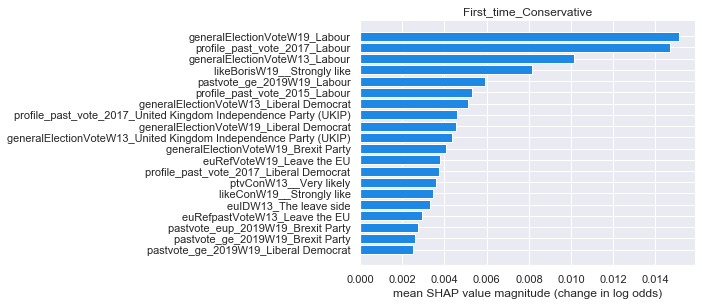

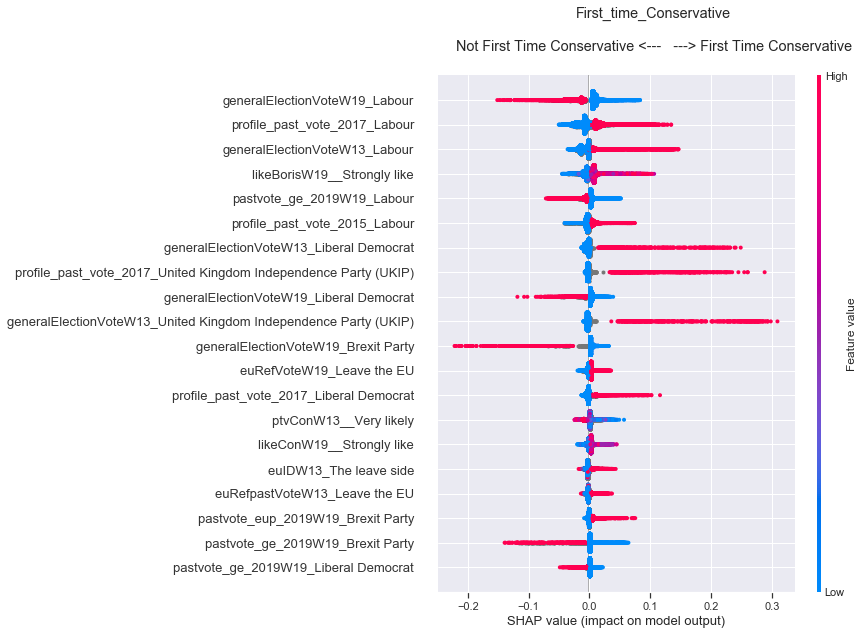

Wall time: 1h 8min 44s


(<shap.explainers.tree.TreeExplainer at 0x2090a108>,
 array([[ 3.6483192e-07, -5.1336716e-05,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 2.8016467e-07, -1.0309804e-05,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 5.7856550e-07, -3.8484736e-06,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        ...,
        [ 5.7856550e-07, -8.9061887e-06,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 4.7173404e-07, -1.3226625e-05,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 5.7856550e-07, -8.9061887e-06,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32))

In [30]:
%%time
colname = "First_time_Conservative"
# BES_cens = BES_cens_base[fertility_columns+age_columns+["leaveHanretty"]+["c11Degree"]]
xgboost_run(subdir=colname,min_features = min(BES_reduced_with_na.shape[1]-1,20),
           title = colname+"\n\nNot First Time Conservative <---   ---> First Time Conservative")

[01:05:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.477565
Will train until validation_0-rmse hasn't improved in 36.4 rounds.
[1]	validation_0-rmse:0.456292
[2]	validation_0-rmse:0.43627
[3]	validation_0-rmse:0.417305
[4]	validation_0-rmse:0.399309
[5]	validation_0-rmse:0.382405
[6]	validation_0-rmse:0.366418
[7]	validation_0-rmse:0.351411
[8]	validation_0-rmse:0.337218
[9]	validation_0-rmse:0.323844
[10]	validation_0-rmse:0.311262
[11]	validation_0-rmse:0.299431
[12]	validation_0-rmse:0.288501
[13]	validation_0-rmse:0.278167
[14]	validation_0-rmse:0.268435
[15]	validation_0-rmse:0.259359
[16]	validation_0-rmse:0.250756
[17]	validation_0-rmse:0.24276
[18]	validation_0-rmse:0.235382
[19]	validation_0-rmse:0.228549
[20]	validation_0-rmse:0.222115
[21]	validation_0-rmse:0.216207
[22]	validation_0-rmse:0.210508
[23]	validation_0-rmse:0.205199
[24]	validation_0-rmse:0.200529
[25]	validation_0-rmse:0.1960

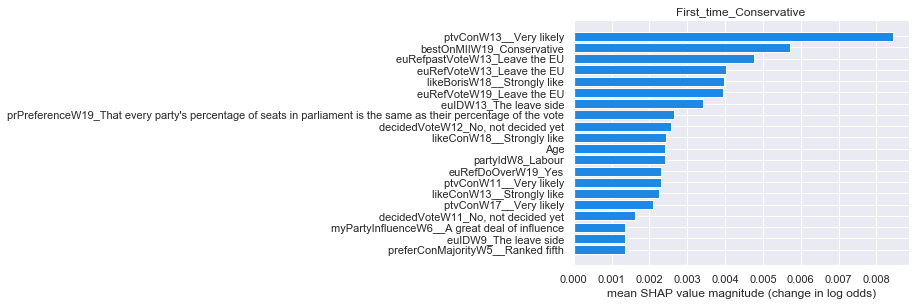

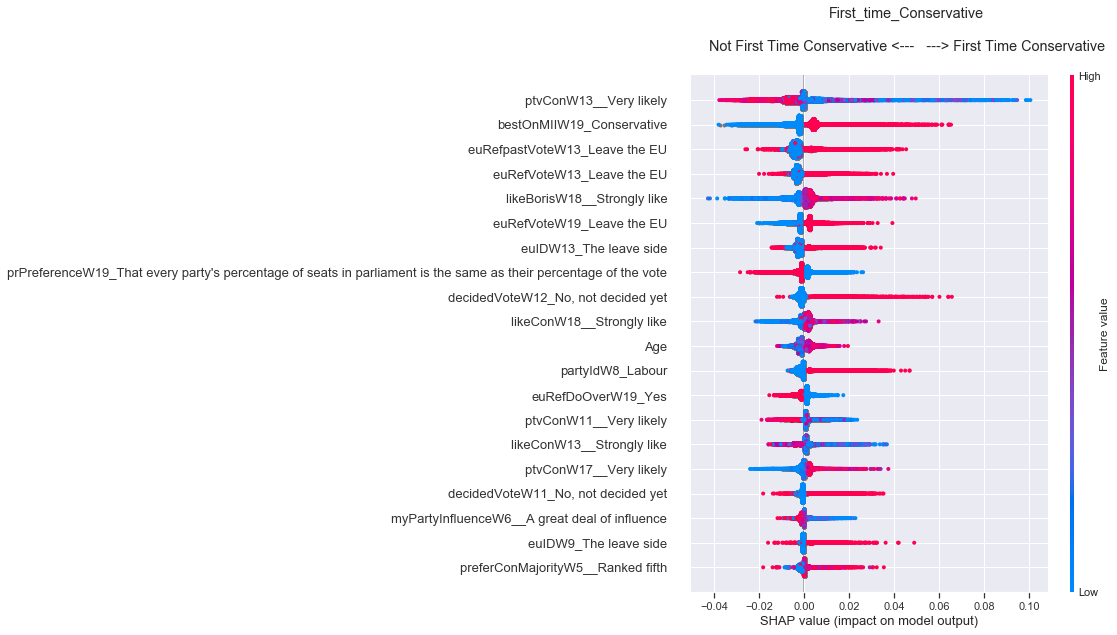

Wall time: 27min 43s


(<shap.explainers.tree.TreeExplainer at 0x4fdc248>,
 array([[ 3.9827846e-06,  0.0000000e+00, -8.0884449e-05, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [-1.0163903e-06,  0.0000000e+00, -3.4675918e-06, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 7.6285835e-07,  0.0000000e+00, -2.0375498e-06, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        ...,
        [ 1.0163903e-06,  0.0000000e+00, -3.4675918e-06, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 1.0688162e-05,  0.0000000e+00, -2.0375498e-06, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 1.0163903e-06,  0.0000000e+00, -3.4675918e-06, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32))

In [33]:
%%time
colname = "First_time_Conservative"
# BES_cens = BES_cens_base[fertility_columns+age_columns+["leaveHanretty"]+["c11Degree"]]
xgboost_run(subdir=colname,min_features = min(BES_reduced_with_na.shape[1]-1,20),
           title = colname+"\n\nNot First Time Conservative <---   ---> First Time Conservative")

In [35]:
Treatment = "First_time_Conservative_compared_against_all_2019_Con_Voters"
var_stub = "First_time_Conservative"

var_list = ["First_time_Conservative"]
var_stub_list = [var_stub,"generalElectionVote","profile_past_vote","likeBorisW19","likeBorisW18","pastvote_ge",
                 "likeConW19","bestOnMIIW19","prPreferenceW19"]

df = BES_reduced_with_na


def optional_mask_fn(wave=[]):
    return BES_Panel["generalElectionVoteW19"]=="Conservative"

[08:17:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.47894
Will train until validation_0-rmse hasn't improved in 14.200000000000001 rounds.
[1]	validation_0-rmse:0.459202
[2]	validation_0-rmse:0.440331
[3]	validation_0-rmse:0.422405
[4]	validation_0-rmse:0.405597
[5]	validation_0-rmse:0.389694
[6]	validation_0-rmse:0.374951
[7]	validation_0-rmse:0.3611
[8]	validation_0-rmse:0.347951
[9]	validation_0-rmse:0.335433
[10]	validation_0-rmse:0.324119
[11]	validation_0-rmse:0.313356
[12]	validation_0-rmse:0.303228
[13]	validation_0-rmse:0.293814
[14]	validation_0-rmse:0.285384
[15]	validation_0-rmse:0.277262
[16]	validation_0-rmse:0.269625
[17]	validation_0-rmse:0.262563
[18]	validation_0-rmse:0.255912
[19]	validation_0-rmse:0.249891
[20]	validation_0-rmse:0.244185
[21]	validation_0-rmse:0.239058
[22]	validation_0-rmse:0.233985
[23]	validation_0-rmse:0.229577
[24]	validation_0-rmse:0.225196
[25]	validation_

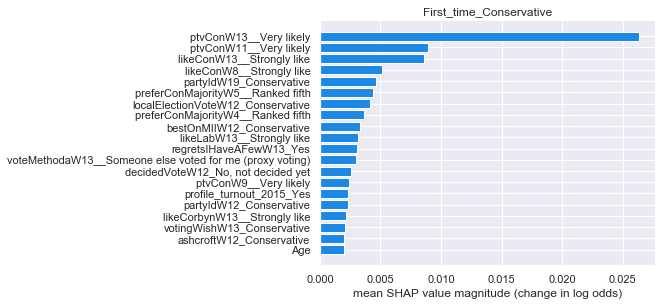

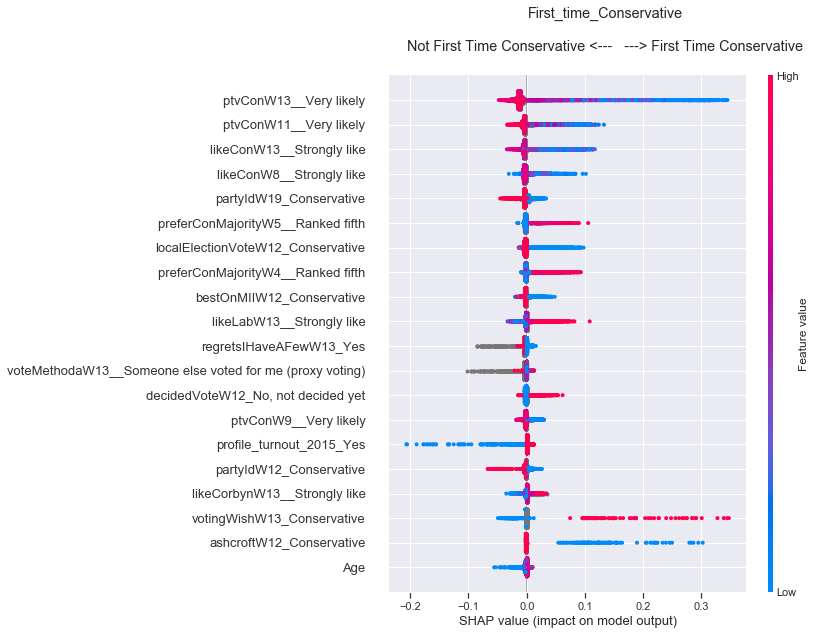

Wall time: 10min 49s


(<shap.explainers.tree.TreeExplainer at 0x209075c8>,
 array([[ 0.0000000e+00,  2.0843506e-06,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00, -2.7931601e-06,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00, -3.6076355e-05,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        ...,
        [ 0.0000000e+00, -3.6076355e-05,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00, -2.7931601e-06,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00, -3.6076355e-05,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32))

In [36]:
%%time
colname = "First_time_Conservative"
# BES_cens = BES_cens_base[fertility_columns+age_columns+["leaveHanretty"]+["c11Degree"]]
xgboost_run(subdir=colname,min_features = min(BES_reduced_with_na.shape[1]-1,20),
           title = colname+"\n\nNot First Time Conservative <---   ---> First Time Conservative")

In [37]:
Treatment = "First_time_Conservative_compared_against_all_2019_Con_Voters"
var_stub = "First_time_Conservative"

var_list = ["First_time_Conservative"]
var_stub_list = [var_stub,"generalElectionVote","profile_past_vote","likeBorisW19","likeBorisW18","pastvote_ge",
                 "likeConW19","bestOnMIIW19","prPreferenceW19","likeCon","ptvCon","bestOnMII","localElectionVote"]

df = BES_reduced_with_na


def optional_mask_fn(wave=[]):
    return BES_Panel["generalElectionVoteW19"]=="Conservative"

[08:58:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.479196
Will train until validation_0-rmse hasn't improved in 13.0 rounds.
[1]	validation_0-rmse:0.459792
[2]	validation_0-rmse:0.44124
[3]	validation_0-rmse:0.424008
[4]	validation_0-rmse:0.407426
[5]	validation_0-rmse:0.392108
[6]	validation_0-rmse:0.377551
[7]	validation_0-rmse:0.36402
[8]	validation_0-rmse:0.351386
[9]	validation_0-rmse:0.339382
[10]	validation_0-rmse:0.328394
[11]	validation_0-rmse:0.317898
[12]	validation_0-rmse:0.307913
[13]	validation_0-rmse:0.29896
[14]	validation_0-rmse:0.290743
[15]	validation_0-rmse:0.282878
[16]	validation_0-rmse:0.27531
[17]	validation_0-rmse:0.268452
[18]	validation_0-rmse:0.262175
[19]	validation_0-rmse:0.256446
[20]	validation_0-rmse:0.250823
[21]	validation_0-rmse:0.245731
[22]	validation_0-rmse:0.240808
[23]	validation_0-rmse:0.236448
[24]	validation_0-rmse:0.232254
[25]	validation_0-rmse:0.228529

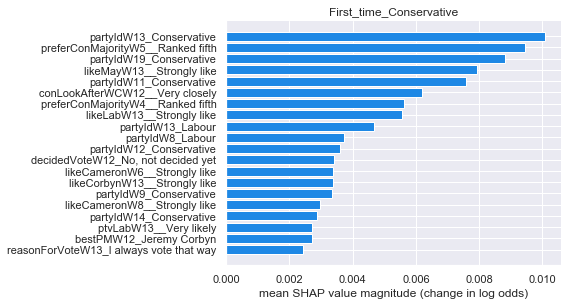

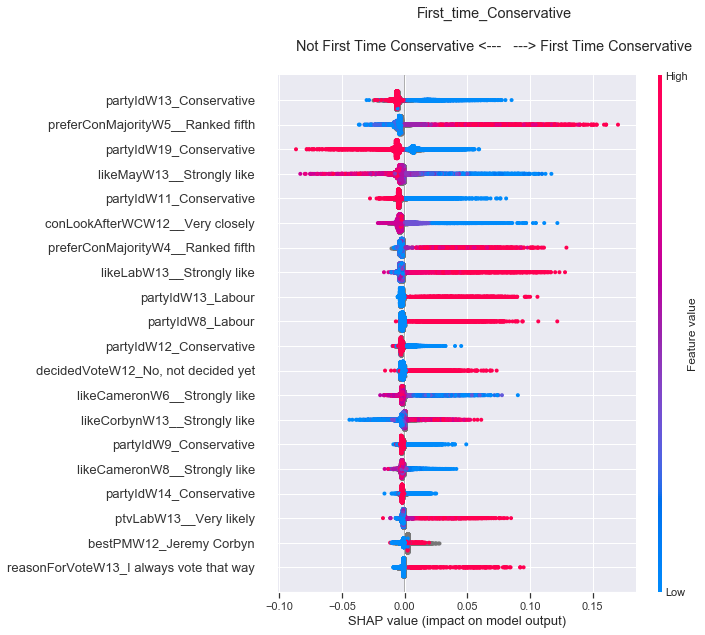

Wall time: 9min 48s


(<shap.explainers.tree.TreeExplainer at 0x209a7908>,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [38]:
%%time
colname = "First_time_Conservative"
# BES_cens = BES_cens_base[fertility_columns+age_columns+["leaveHanretty"]+["c11Degree"]]
xgboost_run(subdir=colname,min_features = min(BES_reduced_with_na.shape[1]-1,20),
           title = colname+"\n\nNot First Time Conservative <---   ---> First Time Conservative")